In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset shape: (247950, 42)
🔥 Random Forest Accuracy (Final Test): 97.28%

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     12854
           1       0.98      0.97      0.97     11941

    accuracy                           0.97     24795
   macro avg       0.97      0.97      0.97     24795
weighted avg       0.97      0.97      0.97     24795


📌 Confusion Matrix:
 [[12576   278]
 [  396 11545]]


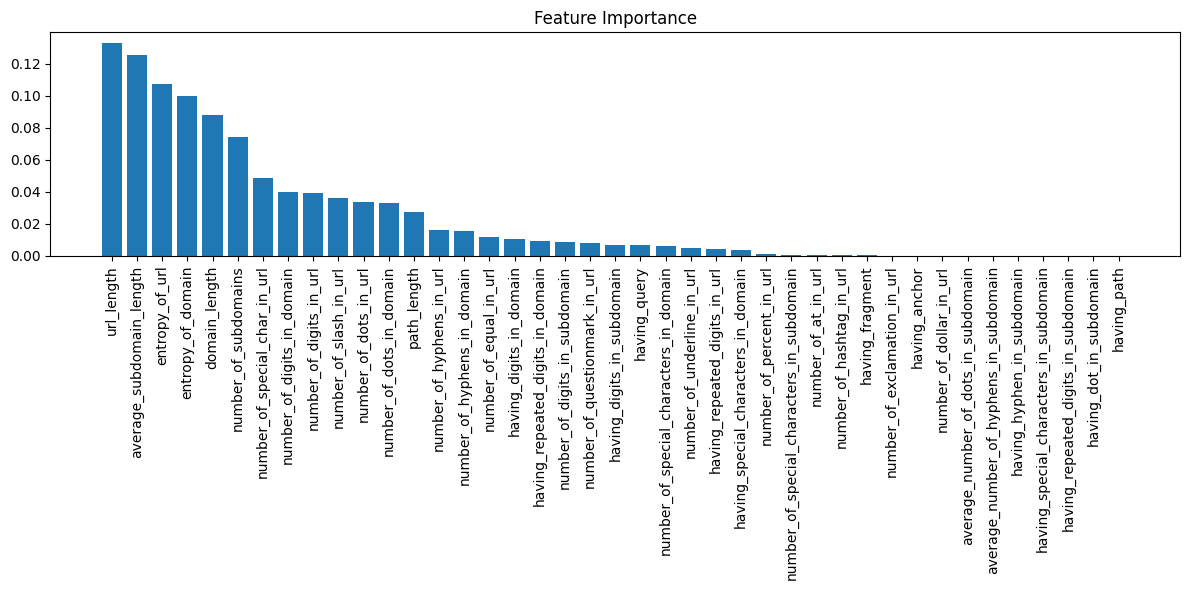

Top features for robustness evaluation: ['average_subdomain_length', 'url_length', 'entropy_of_url']
🔥 Random Forest Accuracy on Noisy Test Data: 93.91%

📌 Classification Report on Noisy Test Data:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     12854
           1       0.95      0.93      0.94     11941

    accuracy                           0.94     24795
   macro avg       0.94      0.94      0.94     24795
weighted avg       0.94      0.94      0.94     24795


📌 Confusion Matrix on Noisy Test Data:
 [[12227   627]
 [  883 11058]]

Model đã được lưu thành công dưới tên 'rf_model.pkl'.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Đọc dữ liệu
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset.csv')
print("Dataset shape:", data.shape)

# Xử lý dữ liệu
# Giả sử cột đầu tiên là nhãn và các cột còn lại là các đặc trưng đã được trích xuất
target_col = data.columns[0]
X = data.iloc[:, 1:]  # Các đặc trưng
y = data[target_col]  # Nhãn

# Nếu y là số liên tục và có nhiều giá trị, chuyển thành nhãn phân loại dựa trên median
if np.issubdtype(y.dtype, np.number) and y.nunique() > 10:
    threshold = y.median()
    y = np.where(y < threshold, 0, 1)

# Chia tập dữ liệu thành train và test (với stratify để giữ tỉ lệ nhãn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Tạo mô hình Random Forest với cấu hình tối ưu
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


# Huấn luyện mô hình trên tập train
rf.fit(X_train, y_train)

# Dự đoán và đánh giá trên tập test
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("🔥 Random Forest Accuracy (Final Test): {:.2f}%".format(acc * 100))
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📌 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Trực quan hóa Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Kiểm tra tính Robustness của mô hình
# Giả sử các feature quan trọng hàng đầu là: average_subdomain_length, url_length, entropy_of_url
# Nếu không có tên này trong dataset, bạn có thể thay thế bằng top 3 feature theo thứ hạng.
top_features = ['average_subdomain_length', 'url_length', 'entropy_of_url']
for f in top_features:
    if f not in X.columns:
        top_features = list(feature_names[indices][:3])
        break
print("Top features for robustness evaluation:", top_features)

# Tạo dữ liệu test có thêm nhiễu cho các feature quan trọng
noise_factor = 0.05  # 5% noise
X_test_noisy = X_test.copy()
for f in top_features:
    X_test_noisy[f] = X_test_noisy[f] * (1 + np.random.normal(0, noise_factor, X_test_noisy[f].shape))

# Dự đoán trên tập dữ liệu test có nhiễu
y_pred_noisy = rf.predict(X_test_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
print("🔥 Random Forest Accuracy on Noisy Test Data: {:.2f}%".format(acc_noisy * 100))
print("\n📌 Classification Report on Noisy Test Data:\n", classification_report(y_test, y_pred_noisy))
print("\n📌 Confusion Matrix on Noisy Test Data:\n", confusion_matrix(y_test, y_pred_noisy))

# Lưu mô hình đã huấn luyện để sử dụng sau này
joblib.dump(rf, 'rf_model.pkl')
print("\nModel đã được lưu thành công dưới tên 'rf_model.pkl'.")
